# TAT-C Deliverable Report

Paul T. Grogan <paul.grogan@asu.edu>

Contributor: Josue Tapia <josue.tapia@asu.edu>

This notebook describes and showcases the TAT-C code to populate refresh rate and data latency values for a given scientific value (rows) in the ASPEN tool. The program relies on the open-source TAT-C Python library. This script utilizes the latest version of tatc (v.3.2.1) available in PyPI. User can install tatc using the pip command:

```
pip install tatc
```
Additionally, this report also relies on the `joblib` and `openpyxl` libraries to process tasks in parallel and write performance metrics into the ASPEN tool. The libraries can be install as follows:

```
pip install joblib
```
```
pip install openpyxl
```

The general purpose of this report is to use tatc as a pre-processor for the Advanced Systems Performance Evaluation Tool for NOAA (ASPEN) Sensor Constellation/Performance (SCP) table. SCP columns that can be informed by tatc analysis include (descriptions from ASPEN-91 definition tables):
* Temporal Refresh
* Data Latency

The tatc library models instrument observability rather than geophysical variables. Instruments selected for this report consist of infrared, microwave sounders, and visual/infrared imagers which correspond to SCP rows. The instruments observe the following geophysical variables:

* Infrared Sounder: Air temeprature, Cloud top temperature, Sea surface temperature, Specific humidity, Land surface temperature
* Microwave Sounder: Air temperature profiles, Specific humidity
* Visual/Infrared Imager: Cloud cover, Cloud top temperature, Fire radiative power, Sea surface temperature, Snow cover

Each of these sensors provides observations to populate the temporal refresh and data latency cells of different rows of the ASPEN tool:

* The infrared sounder sensors fill up rows 13, 54, 17, and 41
* The visual/infrared Imager sensors fill up rows 9, 35, 60, and 47

## Defining Missions
Write satellites/instruments reference
### Instruments
First, we define a suite of sensors on board of NOAA satellites, using tatc's schemas for instruments. We scrapped the sensors specifications from publicly available data such as the World Meteorological Organization [OSCAR Tool](https://space.oscar.wmo.int/instruments).

In [1]:
from tatc.schemas import Instrument
from tatc.utils import (
    swath_width_to_field_of_regard,
    along_track_distance_to_access_time,
)

ref_altitude = 850e3
ref_inclination = 98.6
amsu_a = Instrument(
    name="AMSU-A",
    field_of_regard=swath_width_to_field_of_regard(ref_altitude, 2250000),
    min_access_time=along_track_distance_to_access_time(
        ref_altitude, ref_inclination, 48000
    ),
    fixed_access_time=True,
)
amsu_b = Instrument(
    name="AMSU-B",
    field_of_regard=swath_width_to_field_of_regard(ref_altitude, 2250000),
    min_access_time=along_track_distance_to_access_time(
        ref_altitude, ref_inclination, 16000
    ),
    fixed_access_time=True,
)
mhs = Instrument(
    name="MHS",
    field_of_regard=swath_width_to_field_of_regard(ref_altitude, 2180000),
    min_access_time=along_track_distance_to_access_time(
        ref_altitude, ref_inclination, 16000
    ),
    fixed_access_time=True,
)
atms = Instrument(
    name="ATMS",
    field_of_regard=swath_width_to_field_of_regard(ref_altitude, 2200000),
    min_access_time=along_track_distance_to_access_time(
        ref_altitude, ref_inclination, 16000
    ),
    fixed_access_time=True,
)
hirs_3 = Instrument(
    name="HIRS/3",
    field_of_regard=swath_width_to_field_of_regard(ref_altitude, 2200000),
    min_access_time=along_track_distance_to_access_time(
        ref_altitude, ref_inclination, 42000
    ),
    fixed_access_time=True,
)
hirs_4 = Instrument(
    name="HIRS/4",
    field_of_regard=swath_width_to_field_of_regard(ref_altitude, 2200000),
    min_access_time=along_track_distance_to_access_time(
        ref_altitude, ref_inclination, 42000
    ),
    fixed_access_time=True,
)
cris = Instrument(
    name="CrIS",
    field_of_regard=swath_width_to_field_of_regard(ref_altitude, 2200000),
    min_access_time=along_track_distance_to_access_time(
        ref_altitude, ref_inclination, 48000
    ),
    fixed_access_time=True,
)
avhrr_3_vis = Instrument(
    name="AVHRR/3",
    field_of_regard=swath_width_to_field_of_regard(ref_altitude, 2900000),
    min_access_time=along_track_distance_to_access_time(
        ref_altitude, ref_inclination, 6600
    ),
    fixed_access_time=True,
)
viirs_vis = Instrument(
    name="VIIRS",
    field_of_regard=swath_width_to_field_of_regard(ref_altitude, 3000000),
    min_access_time=along_track_distance_to_access_time(
        ref_altitude, ref_inclination, 11900
    ),
    fixed_access_time=True,
)

### Constellations
Now, we define constellations using infrared and visual/Infrared sounder instruments. We use the NOAA's current LEO constellations. The TLEs were scrapped from a public source such as the [CelesTrak](https://celestrak.org) as of September 2023. 
We start by generating an infrared constellation comprising five satellites: NOAA-15, NOAA-18, NOAA-20, NOAA-21, and Suomi NPP. Since these satellites carry on board multiple instruments that meet different objectives, we name the satellite based on the instrument that we assign.

In [2]:
from tatc.schemas import Satellite, TwoLineElements

noaa_15_hirs_3 = Satellite(
    name="NOAA-15",
    orbit=TwoLineElements(
        tle=[
            "1 25338U 98030A   23269.59105138  .00000329  00000+0  15478-3 0  9996",
            "2 25338  98.6000 296.8875 0010693  24.0363 336.1314 14.26396144319462",
        ]
    ),
    instruments=[hirs_3],
)

noaa_18_hirs_4 = Satellite(
    name="NOAA-18",
    orbit=TwoLineElements(
        tle=[
            "1 28654U 05018A   23269.53943895  .00000353  00000+0  21270-3 0  9992",
            "2 28654  98.9023 343.4078 0015291  93.7598 266.5322 14.13013890945796",
        ]
    ),
    instruments=[hirs_4],
)


snpp_cris = Satellite(
    name="SNPP",
    orbit=TwoLineElements(
        tle=[
            "1 37849U 11061A   23269.53617392  .00000219  00000+0  12472-3 0  9998",
            "2 37849  98.7093 206.5497 0001068  60.2627  50.3317 14.19571070617323",
        ]
    ),
    instruments=[cris],
)

noaa_20_cris = Satellite(
    name="NOAA-20",
    orbit=TwoLineElements(
        tle=[
            "1 43013U 17073A   23269.47916028  .00000193  00000+0  11197-3 0  9992",
            "2 43013  98.7173 206.3490 0001136 107.6181 252.5119 14.19567911303349",
        ]
    ),
    instruments=[cris],
)

noaa_21_cris = Satellite(
    name="NOAA-21",
    orbit=TwoLineElements(
        tle=[
            "1 54234U 22150A   23269.49507492  .00000244  00000+0  13662-3 0  9990",
            "2 54234  98.7211 205.8776 0001553  96.6823 263.4530 14.19552111 45429",
        ]
    ),
    instruments=[cris],
)
infrared_constellation = [
    noaa_15_hirs_3,
    noaa_18_hirs_4,
    snpp_cris,
    noaa_20_cris,
    noaa_21_cris,
]

Now, we generate a second constellation that use the visible imager sensors.

In [3]:
snpp_vis = Satellite(
    name="SNPP",
    orbit=TwoLineElements(
        tle=[
            "1 37849U 11061A   23269.53617392  .00000219  00000+0  12472-3 0  9998",
            "2 37849  98.7093 206.5497 0001068  60.2627  50.3317 14.19571070617323",
        ]
    ),
    instruments=[viirs_vis],
)

noaa_20_vis = Satellite(
    name="NOAA-20",
    orbit=TwoLineElements(
        tle=[
            "1 43013U 17073A   23269.47916028  .00000193  00000+0  11197-3 0  9992",
            "2 43013  98.7173 206.3490 0001136 107.6181 252.5119 14.19567911303349",
        ]
    ),
    instruments=[viirs_vis],
)

noaa_21_vis = Satellite(
    name="NOAA-21",
    orbit=TwoLineElements(
        tle=[
            "1 54234U 22150A   23269.49507492  .00000244  00000+0  13662-3 0  9990",
            "2 54234  98.7211 205.8776 0001553  96.6823 263.4530 14.19552111 45429",
        ]
    ),
    instruments=[viirs_vis],
)
visible_constellation = [snpp_vis, noaa_20_vis, noaa_21_vis]

### Ground Stations


In [4]:
from tatc.schemas import GroundStation

mcmurdo = GroundStation(
    name="McMurdo",
    latitude=-77.846323,
    longitude=166.668235,
    elevation=150,
    min_elevation_angle=5,
)
svalbard = GroundStation(
    name="Svalbard",
    latitude=78.229772,
    longitude=15.407786,
    elevation=450,
    min_elevation_angle=5,
)
fairbanks = GroundStation(
    name="Fairbanks",
    latitude=64.97381,
    longitude=-147.50575,
    elevation=400,
    min_elevation_angle=5,
)
troll = GroundStation(
    name="Troll",
    latitude=-72.016667,
    longitude=2.533333,
    elevation=1275,
    min_elevation_angle=5,
)

stations = [mcmurdo, svalbard, fairbanks, troll]

### Grid Points
We generate our grid of target points that constellations observe. Since the simulation runtime increases non-linearly as the number of target points increases, as a rule of thumb, we recommend using a grid distance equal to twice the size of the sensor swath width.

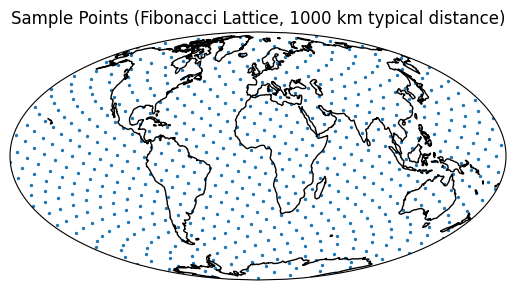

In [5]:
from tatc.generation import generate_fibonacci_lattice_points
from tatc.schemas import Point

grid_distance = 1000e3
points_df = generate_fibonacci_lattice_points(grid_distance)

target_points = points_df.apply(
    lambda r: Point(id=r.point_id, latitude=r.geometry.y, longitude=r.geometry.x),
    axis=1,
)

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

ax = plt.axes(projection=ccrs.Mollweide())
points_df.plot(ax=ax, markersize=2, transform=ccrs.PlateCarree())
ax.coastlines()
plt.title("Sample Points (Fibonacci Lattice, 1000 km typical distance)")
plt.show()

### Simulation Period

In [6]:
from datetime import timedelta, datetime, timezone

start = datetime(year=2023, month=9, day=15, hour=0, minute=0, tzinfo=timezone.utc)
end = start + timedelta(days=30)

### Setting Functions for Parallel Processing

In [7]:
from tatc.analysis.coverage import (
    collect_multi_observations,
    aggregate_observations,
    reduce_observations,
)
from tatc.analysis.latency import collect_downlinks, compute_latencies, reduce_latencies
from joblib import Parallel, delayed
import pandas as pd
import numpy as np


def run_revisit_analysis(constellation, start, end, point):
    """
    Performs revisit time for a constellation and a target point
    """
    results = reduce_observations(
        aggregate_observations(
            collect_multi_observations(point, constellation, start, end)
        )
    )

    return results


def run_latency_analysis(point, constellation, start, end, downlink_opps):
    """
    Performs data latency analysis for a constellation and a target point
    """
    observations = collect_multi_observations(point, constellation, start, end)
    results = reduce_latencies(compute_latencies(observations, downlink_opps))
    results["latency"] = results["latency"].apply(lambda t: t / timedelta(hours=1))
    return np.mean(results.latency)


def revisit_time_request(constellation, start, end, target_points):
    """
    Splits a revisit time request task into small and independent tasks that can be porcessed in parallel
    """
    refresh_list = Parallel(n_jobs=-1)(
        delayed(run_revisit_analysis)(constellation, start, end, point)
        for point in target_points
    )
    refresh = pd.concat(refresh_list, ignore_index=True)

    refresh["revisit_hr"] = refresh.revisit.apply(lambda r: r / timedelta(hours=1))
    return np.mean(refresh.revisit_hr)


def latency_request(constellation, stations, start, end, target_points):
    """
    Splits a latency request task into small and independent tasks that can be porcessed in parallel
    """
    downlink_list = Parallel(n_jobs=-1)(
        delayed(collect_downlinks)(stations, sat, start, end) for sat in constellation
    )
    downlink_opps = pd.concat(downlink_list, ignore_index=True)

    latency_list = Parallel(n_jobs=-1)(
        delayed(run_latency_analysis)(point, constellation, start, end, downlink_opps)
        for point in target_points
    )

    latency_results = [la for la in latency_list if isinstance(la, float)]
    return np.mean(latency_results)

### Populating ASPEN Rows

We use the openpyxl library to open the `SCP_Template_91_variables_April_2023.xlsx` file and write temporal refresh and data latency values. This model assumes that the SCP file is located in the same directory as this script. First, we assign a set of geophysical variables to a constellation with sensor that observe it.

In [8]:
gv_infrared = [
    "Air Temperature: Profiles",
    "Cloud Top Temperature",
    "Specific Humidity",
    "Land Surface Temperature",
]
gv_visible = [
    "Cloud Cover",
    "Fire Radiative Power",
    "Sea Surface Temperature",
    "Snow Cover",
]

Now, we open the SCP file and check how many filled rows exists, assuming that the list starts at row 5. This will avoid looping over empty cells.

In [10]:
import numpy as np
import openpyxl

user_inputs = [
    "Air Temperature: Profiles",
    "Cloud Top Temperature",
    "Specific Humidity",
    "Land Surface Temperature",
    "Cloud Cover",
    "Fire Radiative Power",
    "Sea Surface Temperature",
    "Snow Cover",
]
file = openpyxl.load_workbook("SCP_Template_91_variables_April_2023.xlsx")
my_sheet = file["Generic"]

filled_cell = True
i = 5
while filled_cell:
    if isinstance(my_sheet[f"B{i}"].value, str):
        i += 1
    else:
        filled_cell = False

last_row_index = i - 1

The following script creates two lists of variables that can be observed by infrared or visual instruments. Then, it computes refresh rate and data latency values for each list. The `populate_refresh_latency` function loops over the ASPEN tool to find the row with the geophysical variable the user requested. This function is called repetitively because the same instrument can observe multiple geophysical variables.

In [11]:
def populate_refresh_latency(variable, my_sheet, i, refresh, latency):
    find_row = False
    row_index = 5
    while not find_row:
        if variable == my_sheet[f"B{row_index}"].value:
            my_sheet[f"I{row_index}"] = refresh
            my_sheet[f"R{row_index}"] = latency
            find_row = True
        else:
            if row_index <= i:
                row_index += 1
            else:
                print("The variable does not exists in the SCP Table")
                find_row = True

    return my_sheet


list_of_infrared = []
list_of_visible = []
for val in user_inputs:
    if val in gv_infrared:
        list_of_infrared.append(val)
    elif val in gv_visible:
        list_of_visible.append(val)
if list_of_infrared:
    infra_results_refresh = np.round(
        revisit_time_request(infrared_constellation, start, end, target_points)
        * 60
        * 60,
        2,
    )  # converts to secs
    infra_results_latency = np.round(
        latency_request(infrared_constellation, stations, start, end, target_points)
        * 60
        * 60,
        2,
    )
    for variable in list_of_infrared:
        my_sheet = populate_refresh_latency(
            variable,
            my_sheet,
            last_row_index,
            infra_results_refresh,
            infra_results_latency,
        )

if list_of_visible:
    visual_results_refresh = np.round(
        revisit_time_request(visible_constellation, start, end, target_points)
        * 60
        * 60,
        2,
    )  # converts to secs
    visual_results_latency = np.round(
        latency_request(visible_constellation, stations, start, end, target_points)
        * 60
        * 60,
        2,
    )
    for variable in list_of_visible:
        my_sheet = populate_refresh_latency(
            variable,
            my_sheet,
            last_row_index,
            visual_results_refresh,
            visual_results_latency,
        )

file.save("Populated_ASPEN.xlsx")